In [1]:
import numpy as np
import networkx as nx
import os, time

import os.path as osp
import glob
from wmpgnn.datasets.graph_dataset import CustomDataset
from torch_geometric.loader import DataLoader
import contextlib
import torch
from torch import nn
from torch_scatter import scatter_add


In [2]:

files_input_tr = sorted(glob.glob('/home/sutclw/Work/Zurich/LHCb/GNNs/cached_LCA_training_events_PYTHIA/training_dataset/input_*'))
files_target_tr = sorted(glob.glob('/home/sutclw/Work/Zurich/LHCb/GNNs/cached_LCA_training_events_PYTHIA/training_dataset/target_*'))
data_tr = CustomDataset(files_input_tr, files_target_tr)
dataset_tr = data_tr.get()
print("finish loading training dataset")

files_input_vl = sorted(glob.glob('/home/sutclw/Work/Zurich/LHCb/GNNs/cached_LCA_training_events_PYTHIA/validation_dataset/input_*'))
files_target_vl = sorted(glob.glob('/home/sutclw/Work/Zurich/LHCb/GNNs/cached_LCA_training_events_PYTHIA/validation_dataset/target_*'))
data_vl = CustomDataset(files_input_vl, files_target_vl)
dataset_vl = data_vl.get()
print("finish loading validation dataset")

finish loading training dataset
finish loading validation dataset


In [3]:
NUM_LAYERS = 5
HIDDEN_CHANNELS=128

In [4]:
BATCH_SIZE = 32
loader_tr = DataLoader(dataset_tr, batch_size=BATCH_SIZE, drop_last=True)
loader_vl = DataLoader(dataset_vl, batch_size=BATCH_SIZE, drop_last=True)

In [5]:
for vdata in loader_vl:
    break

In [6]:
vdata

DataBatch(y=[117026, 4], nodes=[3018, 4], edges=[117026, 4], senders=[117026], receivers=[117026], graph_globals=[32], edgepos=[117026], num_edges=[32], num_nodes=3018, batch=[3018], ptr=[33])

In [7]:
#import wmpgnn.model.gnn_model 
#import wmpgnn.gnn.graph_network

In [8]:
from wmpgnn.model.gnn_model import EncodeProcessDecode

In [9]:
import importlib
#importlib.reload(wmpgnn.model)
#importlib.reload(wmpgnn.model.gnn_model)
#importlib.reload(wmpgnn.gnn.graph_network)
#importlib.reload(gnn_model)

In [10]:
MLP_OUTPUT_SIZE=8

myModel=EncodeProcessDecode(mlp_output_size=MLP_OUTPUT_SIZE, edge_op=4)

In [11]:
myModel._blocks[0]._network

GraphNetwork(
  (_edge_block): EdgeBlock(
    (_edge_model): MLP(-1, 128, 128, 128, 8)
  )
  (_node_block): NodeBlock(
    (_node_model): MLP(-1, 128, 128, 128, 8)
    (_sent_edges_aggregator): EdgesToNodesAggregator()
  )
  (_global_block): GlobalBlock(
    (_global_model): MLP(-1, 128, 128, 128, 8)
    (_edges_aggregator): EdgesToGlobalsAggregator()
    (_nodes_aggregator): NodesToGlobalsAggregator()
  )
  (edge_linear): Linear(in_features=8, out_features=1, bias=True)
  (edge_mlp): MLP(-1, 16, 16, 16, 1)
  (node_linear): Linear(in_features=8, out_features=1, bias=True)
  (node_mlp): MLP(-1, 16, 16, 16, 1)
  (sigmoid): Sigmoid()
  (select): SelectTopK(1, ratio=20)
  (select_nodes): SelectTopK(1, ratio=70)
)

In [12]:
from wmpgnn.util.functions import weight_four_class, acc_four_class

In [13]:
weights=weight_four_class(loader_tr)

tensor([2.5158e-01, 1.7982e+02, 6.0619e+01, 3.2675e+02])


In [14]:
!ls *.pth

model_27_epochs_pruning_latest.pth
model_32_8block_epochs_pruning_latest.pth
model_32_epochs_pruning_latest.pth
model_34_6block_epochs_pruning_scattermean.pth


In [13]:
dic = torch.load('model_32_8block_epochs_pruning_latest.pth')

In [14]:
dic.keys()

odict_keys(['_encoder._network._edge_model._model.lins.0.weight', '_encoder._network._edge_model._model.lins.0.bias', '_encoder._network._edge_model._model.lins.1.weight', '_encoder._network._edge_model._model.lins.1.bias', '_encoder._network._edge_model._model.lins.2.weight', '_encoder._network._edge_model._model.lins.2.bias', '_encoder._network._edge_model._model.lins.3.weight', '_encoder._network._edge_model._model.lins.3.bias', '_encoder._network._node_model._model.lins.0.weight', '_encoder._network._node_model._model.lins.0.bias', '_encoder._network._node_model._model.lins.1.weight', '_encoder._network._node_model._model.lins.1.bias', '_encoder._network._node_model._model.lins.2.weight', '_encoder._network._node_model._model.lins.2.bias', '_encoder._network._node_model._model.lins.3.weight', '_encoder._network._node_model._model.lins.3.bias', '_encoder._network._global_model._model.lins.0.weight', '_encoder._network._global_model._model.lins.0.bias', '_encoder._network._global_mod

In [15]:
for par in myModel.named_parameters():
    print(par[0])
    print(par[1].shape)
    print(dic[par[0]].shape)
    print(par[1].shape == dic[par[0]].shape)
    #print(par[1].shape)
    #print(dic[par[0]].shape)

_encoder._network._edge_model._model.lins.0.weight


RuntimeError: Can't access the shape of an uninitialized parameter or buffer. This error usually happens in `load_state_dict` when trying to load an uninitialized parameter into an initialized one. Call `forward` to initialize the parameters before accessing their attributes.

In [12]:
for par in myModel.named_parameters():
    print(par[0])
    #print(par[1].shape)
    print(dic[par[0]].shape)

_encoder._network._edge_model._model.lins.0.weight


NameError: name 'dic' is not defined

In [15]:

myModel=EncodeProcessDecode(mlp_output_size=MLP_OUTPUT_SIZE, edge_op=4, num_blocks=8)

myModel.cuda()

optimizer = torch.optim.Adam(myModel.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=weights)
pos_weight = torch.tensor([166.128])  

criterionBCE = nn.BCELoss(weight=pos_weight) 
pos_weight = torch.tensor([15.5])
criterionBCEnodes = nn.BCELoss(weight=pos_weight) 

criterion.to('cuda')
criterionBCE.cuda()
criterionBCEnodes.cuda()

BCELoss()

In [16]:
last_batch = len(loader_tr)

def train_one_epoch(epoch_index):
    
    running_loss = 0.
    last_loss = 0.
    acc_one_epoch = []
    if epoch_index > 100:
        # don't use this right now
        #myModel._blocks[2]._network.node_prune = True
        #myModel._blocks[2]._network.edge_prune = False
        #myModel._blocks[2]._network.prune_by_cut = False
        #myModel._blocks[1]._network.prune_by_cut = True
        #myModel._blocks[1]._network.edge_prune = True
        #myModel._blocks[1]._network.edge_weight_cut = 0.005
        #myModel._blocks[2]._network.edge_weight_cut = 0.005
        #myModel._core2._network.select_nodes = SelectTopK(1,40).cuda()
        #myModel.ratio = 0.75
        print("pruning on ")
    for i, data in enumerate(loader_tr): 
        data['graph_globals'] = data['graph_globals'].unsqueeze(1)
        data.receivers = data.receivers - torch.min(data.receivers)
        data.senders = data.senders - torch.min(data.senders)
        data.edgepos = data.edgepos - torch.min(data.edgepos)
        optimizer.zero_grad()
        #print(data)
        data.to('cuda')
        #print("shape before ", data.y.shape)
        yBCE_start = 1.*(data.y[:,0]==0).unsqueeze(1)
        num_nodes=data.nodes.shape[0]
        out = data.edges.new_zeros(num_nodes, data.edges.shape[1])
        node_sum = scatter_add(data.y,data.senders,out=out,dim=0)
        ynodes_start = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
        
        label0 = data.y.argmax(dim=1)
        #print("first label0 ",label0)
        answers = torch.ones_like(data.edges).cuda()
        #print(data)
        outputs = myModel(data, num_processing_steps=STEP_SIZE)
        #print(outputs)
        data = outputs

        #print('after', data)        
        #ycopy = data.y.copy()
        #print("shape after ", data.y.shape)
        label= data.y.argmax(dim=1)
        num_nodes=data.nodes.shape[0]
        out = data.edges.new_zeros(num_nodes, data.edges.shape[1])
        node_sum = scatter_add(data.y,data.senders,out=out,dim=0)
        ynodes = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
    #         print(data.y)
#         label= data.y
#         print(outputs.edges)
#         break
#         pred = torch.softmax(outputs.edges, dim=1)
        if myModel._blocks[2]._network.node_prune == True:
            #indices= myModel._blocks[2]._network.edge_indices
            indices = myModel._blocks[2]._network.edge_node_pruning_indices
            #print(label.shape)
            #print(outputs)
            loss = criterion(outputs.edges, label) 
            #print("label0 ",label0)
            index = torch.ones(label0.shape[0], dtype=bool).cuda()
            index[indices] = False
            selected_labels = label0[index]
            answers[:,1:] = 0
            answers[indices] = outputs.edges
            num_nodes=data.nodes.shape[0]
            out = data.edges.new_zeros(num_nodes, data.edges.shape[1])
            node_sum = scatter_add(data.y,data.senders,out=out,dim=0)
            ynodes = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
            #loss += criterion(answers[index], selected_labels)
            yBCE = 1.*(data.y[:,0]==0).unsqueeze(1)
            #print(myModel.blocks[2]._network.edge_weights.shape)
            #print('shape later ', yBCE.shape)
            for block in myModel._blocks:
                if block._network.edge_prune:
                    yBCE_start = yBCE_start[block._network.edge_indices ]
                    loss += 0.2*criterionBCE(block._network.edge_weights, yBCE_start)
                if block._network.node_prune:
                    yBCE_start = yBCE_start[block._network.edge_node_pruning_indices ]
                    loss += 0.2*criterionBCE(block._network.edge_weights, yBCE_start)
                else:
                    loss += 0.2*criterionBCE(block._network.edge_weights, yBCE_start)
                if block._network.node_prune:
                    ynodes_start = ynodes_start[block._network.node_indices]
                    loss += 0.2*criterionBCEnodes(block._network.node_weights, ynodes_start)                    
                else:
                    loss += 0.2*criterionBCEnodes(block._network.node_weights, ynodes_start)
        else:
            loss = criterion(outputs.edges, label) 
        #loss = criterion(outputs.edges, label) 
            yBCE = 1.*(data.y[:,0]==0).unsqueeze(1)
            for block in myModel._blocks:
                loss += 0.2*criterionBCE(block._network.edge_weights, yBCE)
                loss += 0.2*criterionBCEnodes(block._network.node_weights, ynodes)
                

    
        loss.backward()

        if myModel._blocks[2]._network.node_prune:
           acc_one_batch = acc_four_class(answers, label0)
        else:
            acc_one_batch = acc_four_class(outputs.edges, label)
        acc_one_epoch.append(acc_one_batch)
        # Adjust learning weights
        optimizer.step()
#         break
        # Gather data and report
        running_loss += loss.item()
        if (i+1) == last_batch:
            last_loss = running_loss / last_batch # loss per batch
            print('  batch {} last_batch {} loss: {}'.format(i + 1, last_batch, last_loss))

            running_loss = 0.
    
        
    acc_one_epoch=torch.stack(acc_one_epoch)

    return last_loss, acc_one_epoch.nanmean(dim=0)

In [17]:
last_batch_vl = len(loader_vl)

def eval_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    acc_one_epoch = []
    
    for j, vdata in enumerate(loader_vl): 

        vdata['graph_globals'] = vdata['graph_globals'].unsqueeze(1)
        vdata.receivers = vdata.receivers - torch.min(vdata.receivers)
        vdata.senders = vdata.senders - torch.min(vdata.senders)
        vdata.edgepos = vdata.edgepos - torch.min(vdata.edgepos)
        vdata.to('cuda')
        yBCE_start = 1.*(vdata.y[:,0]==0).unsqueeze(1)
        num_nodes=vdata.nodes.shape[0]
        out = vdata.edges.new_zeros(num_nodes, vdata.edges.shape[1])
        node_sum = scatter_add(vdata.y,vdata.senders,out=out,dim=0)
        ynodes_start = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
        
        label0 = vdata.y.argmax(dim=1)
        answers = torch.ones_like(vdata.edges).cuda()

        outputs = myModel(vdata, num_processing_steps=STEP_SIZE)

        vdata = outputs
        label= vdata.y.argmax(dim=1)

        num_nodes=vdata.nodes.shape[0]
        out = vdata.edges.new_zeros(num_nodes, vdata.edges.shape[1])
        node_sum = scatter_add(vdata.y,vdata.senders,out=out,dim=0)
        ynodes = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
#         label= vdata.y
        
#         loss = criterion(outputs.edges, label)
#         loss = criterion.loss(outputs.edges, vdata.y)
#         pred = torch.softmax(outputs.edges, dim=1)
        #if myModel._blocks[3]._network.edge_prune == True:
        if myModel._blocks[2]._network.node_prune == True:
            #indices= myModel._blocks[3]._network.edge_indices
            #indices= myModel._blocks[3]._network.edge_index
            indices = myModel._blocks[2]._network.edge_node_pruning_indices
            
            #print(label.shape)
            loss = criterion(outputs.edges, label) 
            index = torch.ones(label0.shape[0], dtype=bool).cuda()
            index[indices] = False
            selected_labels = label0[index]
            answers[:,1:] = 0
            answers[indices] = outputs.edges
            num_nodes=vdata.nodes.shape[0]
            out = vdata.edges.new_zeros(num_nodes, vdata.edges.shape[1])
            node_sum = scatter_add(vdata.y,vdata.senders,out=out,dim=0)
            ynodes = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
            # include missing graph 
            #loss += criterion(answers[index], selected_labels)
            yBCE = 1.*(vdata.y[:,0]==0).unsqueeze(1)
            for block in myModel._blocks:
                if block._network.edge_prune:
                    yBCE_start = yBCE_start[block._network.edge_indices ]
                    loss += 0.2*criterionBCE(block._network.edge_weights, yBCE_start)
                if block._network.node_prune:
                    yBCE_start = yBCE_start[block._network.edge_node_pruning_indices ]
                    loss += 0.2*criterionBCE(block._network.edge_weights, yBCE_start)
                else:
                    loss += 0.2*criterionBCE(block._network.edge_weights, yBCE_start)
                if block._network.node_prune:
                    #ynodes_start = ynodes_start[block._network.node_indices]
                    loss += 0.2*criterionBCEnodes(block._network.node_weights, ynodes_start)                    
                else:
                    loss += 0.2*criterionBCEnodes(block._network.node_weights, ynodes_start)
        else:
            loss = criterion(outputs.edges, label) 
            yBCE = 1.*(vdata.y[:,0]==0).unsqueeze(1)
            for block in myModel._blocks:
                loss += 0.2*criterionBCE(block._network.edge_weights, yBCE)
                loss += 0.2*criterionBCEnodes(block._network.node_weights, ynodes)

        #if myModel._blocks[3]._network.edge_prune:
        if myModel._blocks[2]._network.node_prune == True:
            acc_one_batch = acc_four_class(answers, label0)
        else:
            acc_one_batch = acc_four_class(outputs.edges, label)
        acc_one_epoch.append(acc_one_batch)
#         break
        # Gather data and report
        running_loss += loss.item()
        if (j+1) == last_batch_vl:
            last_loss = running_loss / last_batch_vl # loss per batch
            print(' validation: batch {} last_batch {} loss: {}'.format(j + 1, last_batch_vl, last_loss))
            running_loss = 0.
    
    acc_one_epoch=torch.stack(acc_one_epoch)

    return last_loss, acc_one_epoch.nanmean(dim=0)

In [18]:
STEP_SIZE = 2

lst_tr_loss = []
lst_vl_loss = []

lst_vl_acc = []
lst_tr_acc = []
start = time.time()

epoch_number = 0

EPOCHS = 30

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print("epoch no. ", (epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    myModel.train(True)
    tr_loss, tr_acc= train_one_epoch(epoch_number)
    lst_tr_loss.append(tr_loss)
    lst_tr_acc.append(tr_acc)
#     break
    # We don't need gradients on to do reporting
    myModel.train(False)
    vl_loss, vl_acc= eval_one_epoch(epoch_number)
    lst_vl_loss.append(vl_loss)
    lst_vl_acc.append(vl_acc)
    
    print(f'Train Loss: {tr_loss:03f}')
    
    epoch_number += 1
    

end = time.time()

epoch no.  1


KeyboardInterrupt: 

In [ ]:
myModel.train(False)
vl_loss, vl_acc= eval_one_epoch(epoch_number)
lst_vl_loss.append(vl_loss)
lst_vl_acc.append(vl_acc)

In [29]:
lst_vl_acc

[tensor([0.9822, 0.7619, 0.5001, 0.8182])]

In [28]:
lst_vl_acc[-1]

tensor([0.9822, 0.7619, 0.5001, 0.8182])

In [155]:
lst_vl_acc[-1]

tensor([0.9779, 0.3284, 0.7154, 0.6827])

In [18]:
!ls

acc_LCAloss_BCE_pruning_from_epoch_30_8.png
acc_LCAloss_BCE_pruning_from_epoch_30_new_2.png
acc_LCAloss_BCE_pruning_from_epoch_30_new_3.png
acc_LCAloss_BCE_pruning_from_epoch_30_new.png
LCA_pruning_for_Azusa.ipynb
loss_new_2.png
loss_new_3.png
loss_new.png
loss.png
model_27_epochs_pruning_latest.pth
model_32_8block_epochs_pruning_latest.pth
model_32_epochs_pruning_latest.pth
model_34_6block_epochs_pruning_scattermean.pth
Test.ipynb
wmpgnn


In [ ]:
#myModel=EncodeProcessDecode(mlp_output_size=MLP_OUTPUT_SIZE, edge_op=4, num_blocks=8)
#myModel.load_state_dict(torch.load('model_32_8block_epochs_pruning_latest.pth'))
myModel.load_state_dict(torch.load('model_32_8block_epochs_pruning_latest.pth'))
myModel.eval()
myModel.cuda()

In [19]:
loader_vl = DataLoader(dataset_vl, batch_size=32, drop_last=True)
for vdata in loader_vl:
    break

In [20]:
vdata
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)


In [21]:
vdata['graph_globals'] = vdata['graph_globals'].unsqueeze(1)
vdata.receivers = vdata.receivers - torch.min(vdata.receivers)
vdata.senders = vdata.senders - torch.min(vdata.senders)
vdata.edgepos = vdata.edgepos - torch.min(vdata.edgepos)
vdata.cuda()
myModel.cuda()

EncodeProcessDecode(
  (_encoder): MLPGraphIndependent(
    (_network): GraphIndependent(
      (_edge_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 8)
      )
      (_node_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 8)
      )
      (_global_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 8)
      )
    )
  )
  (_core): MLPGraphNetwork(
    (_network): GraphNetwork(
      (_edge_block): EdgeBlock(
        (_edge_model): MLP(-1, 128, 128, 128, 8)
      )
      (_node_block): NodeBlock(
        (_node_model): MLP(-1, 128, 128, 128, 8)
        (_sent_edges_aggregator): EdgesToNodesAggregator()
      )
      (_global_block): GlobalBlock(
        (_global_model): MLP(-1, 128, 128, 128, 8)
        (_edges_aggregator): EdgesToGlobalsAggregator()
        (_nodes_aggregator): NodesToGlobalsAggregator()
      )
      (edge_linear): Linear(in_features=8, out_features=1, bias=True)
      (edge_mlp): MLP(-1, 16, 16, 16, 1)


In [22]:
#out

In [23]:
vdata

DataBatch(y=[117026, 4], nodes=[3018, 4], edges=[117026, 4], senders=[117026], receivers=[117026], graph_globals=[32, 1], edgepos=[117026], num_edges=[32], num_nodes=3018, batch=[3018], ptr=[33])

In [24]:
vdata.edgepos.shape

torch.Size([117026])

In [25]:
vdata

DataBatch(y=[117026, 4], nodes=[3018, 4], edges=[117026, 4], senders=[117026], receivers=[117026], graph_globals=[32, 1], edgepos=[117026], num_edges=[32], num_nodes=3018, batch=[3018], ptr=[33])

In [26]:
from torch_geometric.nn.pool.select import SelectTopK
#myModel._blocks[2]._network.node_prune = True
#myModel._blocks[1]._network.node_prune = False
#myModel._blocks[2]._network.prune_by_cut = True
#myModel._blocks[1]._network.prune_by_cut = False

myModel._blocks[2]._network.node_prune = True
myModel._blocks[2]._network.prune_by_cut = True
myModel._blocks[2]._network.node_weight_cut = 0.001
#myModel._blocks[2]._network.device = 'cpu'
# myModel._blocks[3]._network.edge_prune = True
# myModel._blocks[3]._network.prune_by_cut = True
# myModel._blocks[3]._network.edge_weight_cut = 0.001
# myModel._blocks[3]._network.device = 'cpu'
#myModel._blocks[2]._network.select_nodes = SelectTopK(1 ,60).cuda()
# myModel._blocks[4]._network.node_prune = True
# myMoout = myModel(vdata, num_processing_steps=STEP_SIZE)del._blocks[4]._network.prune_by_cut = True
# myModel._blocks[4]._network.node_weight_cut = 0.02

In [27]:
out = myModel(vdata, num_processing_steps=STEP_SIZE)

How nodes should be  tensor([[ 71.9309,  60.1754,  76.1086,  ...,  58.0367, -31.9290,  77.2153],
        [ 71.9309,  60.1754,  76.1086,  ...,  58.0367, -31.9290,  77.2153],
        [ 71.9309,  60.1754,  76.1086,  ...,  58.0367, -31.9290,  77.2153],
        ...,
        [ 63.0708,  56.4929,  71.2664,  ...,  55.0893, -30.1216,  74.7465],
        [ 63.1131,  56.5527,  71.3459,  ...,  55.1406, -30.1357,  74.8177],
        [ 63.1131,  56.5527,  71.3459,  ...,  55.1406, -30.1357,  74.8177]],
       device='cuda:0', grad_fn=<IndexBackward0>)
How nodes are  tensor([[ 71.9309,  60.1754,  76.1086,  ...,  58.0367, -31.9290,  77.2153],
        [ 71.9309,  60.1754,  76.1086,  ...,  58.0367, -31.9290,  77.2153],
        [ 71.9309,  60.1754,  76.1086,  ...,  58.0367, -31.9290,  77.2153],
        ...,
        [ 63.0708,  56.4929,  71.2664,  ...,  55.0893, -30.1216,  74.7465],
        [ 63.1131,  56.5527,  71.3459,  ...,  55.1406, -30.1357,  74.8177],
        [ 63.1131,  56.5527,  71.3459,  ...,  55.14

In [100]:
myModel.cuda()

EncodeProcessDecode(
  (_encoder): MLPGraphIndependent(
    (_network): GraphIndependent(
      (_edge_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 8)
      )
      (_node_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 8)
      )
      (_global_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 8)
      )
    )
  )
  (_core): MLPGraphNetwork(
    (_network): GraphNetwork(
      (_edge_block): EdgeBlock(
        (_edge_model): MLP(-1, 128, 128, 128, 8)
      )
      (_node_block): NodeBlock(
        (_node_model): MLP(-1, 128, 128, 128, 8)
        (_sent_edges_aggregator): EdgesToNodesAggregator()
      )
      (_global_block): GlobalBlock(
        (_global_model): MLP(-1, 128, 128, 128, 8)
        (_edges_aggregator): EdgesToGlobalsAggregator()
        (_nodes_aggregator): NodesToGlobalsAggregator()
      )
      (edge_linear): Linear(in_features=8, out_features=1, bias=True)
      (edge_mlp): MLP(-1, 16, 16, 16, 1)


In [101]:
vdata.to('cpu')
myModel.to('cpu')
start = time.time()
out = myModel(vdata, num_processing_steps=STEP_SIZE)
end = time.time()

In [102]:
end-start

0.02920699119567871

In [103]:
end-start

0.02920699119567871

In [79]:
out.edges[out.y[:,2]==1]

tensor([[-4.7262,  2.0500,  2.1906,  2.4734],
        [-4.1754,  1.6200,  1.8077,  3.1459],
        [-4.6470,  2.0758,  2.1594,  2.1059],
        [-4.6815,  1.8333,  2.6196,  2.3198],
        [-3.9594,  0.8443,  3.1695,  2.2800],
        [-4.8643,  2.0926,  2.4292,  2.4079],
        [-3.8040,  1.0009,  2.6933,  2.7700],
        [-4.2301,  1.5587,  1.9637,  3.4328],
        [-4.7912,  2.0293,  2.4728,  2.2825],
        [-4.7462,  2.0744,  2.1791,  2.4700],
        [-4.5197,  1.4226,  3.1521,  1.8997],
        [-4.7969,  2.0293,  2.5279,  2.1828]], grad_fn=<IndexBackward0>)

In [155]:
out.y[:,1]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

(array([0.        , 0.        , 0.        , 0.        , 0.12820514,
        0.1282051 , 0.12820517, 0.2564102 , 0.12820517, 0.        ,
        0.1282051 , 0.        , 0.38461575, 0.2564102 , 0.1282051 ,
        0.38461529, 0.38461529, 0.89743675, 0.64102549, 0.2564102 ,
        0.64102625, 0.25640989, 0.64102625, 0.25640989, 0.7692315 ,
        0.2564105 , 0.25640989, 0.512821  , 0.25640989, 0.12820525,
        0.12820525, 0.12820494, 0.2564105 , 0.12820494, 0.2564105 ,
        0.12820525, 0.12820494, 0.2564105 , 0.12820494, 0.        ,
        0.        , 0.2564105 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        , 1.10000002, 1.20000005, 1.29999995, 1.39999998,
        1.5       , 1.60000002, 1.70000005, 1.79999995, 1.89999998,
        2.        , 2.0999999 , 2.20000005, 2.

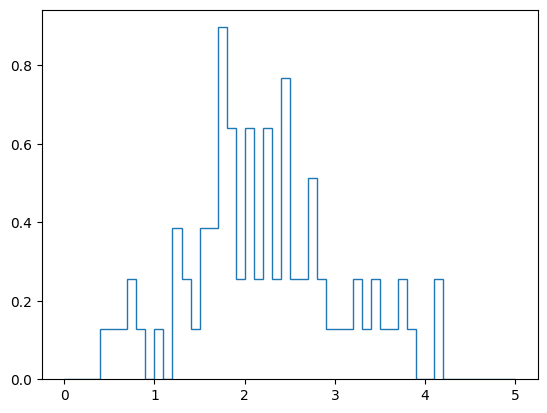

In [160]:
import matplotlib.pyplot as plt
plt.hist(out.edges[out.y[:,1]==1][:,1].detach().cpu().numpy(),density=True, histtype='step',range=(0,5),bins=50,label= "LCA=0")

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.14084504, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.14084487, 0.1408452 , 0.28168974, 0.28169041,
        0.28169041, 0.70422434, 0.28169041, 0.70422434, 0.42253561,
        0.28169041, 0.84506921, 0.56338082, 0.42253461, 0.1408452 ,
        0.28169041, 0.42253461, 0.1408452 , 0.70422434, 0.        ,
        0.28169041, 0.42253561, 0.70422267, 0.1408452 , 0.1408452 ,
        0.        , 0.42253561, 0.28168907, 0.28169041, 0.1408452 ]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        , 1.10000002, 1.20000005, 1.29999995, 1.39999998,
        1.5       , 1.60000002, 1.70000005, 1.79999995, 1.89999998,
        2.        , 2.0999999 , 2.20000005, 2.

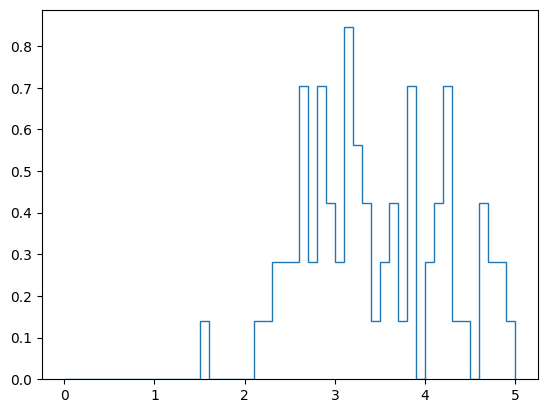

In [178]:
import matplotlib.pyplot as plt
plt.hist(out.edges[out.y[:,1]==1][:,1].detach().cpu().numpy(),density=True, histtype='step',range=(0,5),bins=50,label= "LCA=0")

In [86]:
# start.record()
# out = myModel(vdata, num_processing_steps=STEP_SIZE)
# end.record()
# torch.cuda.synchronize()
# start.elapsed_time(end)

In [42]:
53.53887939453125


53.53887939453125

In [238]:
end-start

TypeError: unsupported operand type(s) for -: 'Event' and 'Event'

In [241]:
vdata

DataBatch(y=[117026, 4], nodes=[3018, 8], edges=[117026, 8], senders=[117026], receivers=[117026], graph_globals=[32, 8], edgepos=[117026], num_edges=[32], num_nodes=3018, batch=[3018], ptr=[33])

In [242]:
out

DataBatch(y=[3972, 4], nodes=[413, 8], edges=[3972, 4], senders=[3972], receivers=[3972], graph_globals=[32, 8], edgepos=[3972], num_edges=[32], num_nodes=3018, batch=[413], ptr=[33])

In [44]:
9347/117026

0.07987113974672296

In [149]:
#torch.sum(vdata.y[myModel._blocks[2]._network.edge_node_pruning_indices][:,0]==0)

In [150]:
#torch.sum(vdata.y[~myModel._blocks[2]._network.edge_node_pruning_indices][:,0]==1)

In [156]:
torch.sum(out.y[:,0]==0)

tensor(564, device='cuda:0')

In [152]:
2691/117026

0.022994890024439014

In [157]:
torch.sum(vdata.y[:,0]==0)

tensor(564, device='cuda:0')

In [224]:
vdata

DataBatch(y=[117026, 4], nodes=[3018, 8], edges=[117026, 8], senders=[117026], receivers=[117026], graph_globals=[32, 8], edgepos=[117026], num_edges=[32], num_nodes=3018, batch=[3018], ptr=[33])

In [225]:
out

DataBatch(y=[53654, 4], nodes=[2117, 8], edges=[53654, 4], senders=[53654], receivers=[53654], graph_globals=[32, 8], edgepos=[53654], num_edges=[32], num_nodes=3018, batch=[2117], ptr=[33])

In [55]:
num_nodes=vdata.nodes.shape[0]
out = vdata.edges.new_zeros(num_nodes, vdata.edges.shape[1])
node_sum = scatter_add(vdata.y,vdata.senders,out=out,dim=0)
ynodes = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)

In [111]:
node_sum

tensor([[57.,  0.,  0.,  ...,  0.,  0.,  0.],
        [62.,  0.,  0.,  ...,  0.,  0.,  0.],
        [63.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [15.,  0.,  0.,  ...,  0.,  0.,  0.],
        [11.,  0.,  0.,  ...,  0.,  0.,  0.],
        [12.,  0.,  0.,  ...,  0.,  0.,  0.]], device='cuda:0')

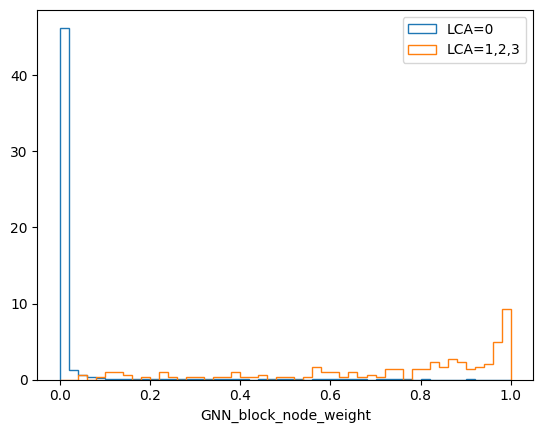

In [59]:
import matplotlib.pyplot as plt
plt.hist(myModel._blocks[2]._network.node_weights[ynodes==0].detach().cpu().numpy(),density=True, histtype='step',range=(0,1),bins=50,label= "LCA=0")
plt.hist(myModel._blocks[2]._network.node_weights[ynodes==1].detach().cpu().numpy(), density=True, histtype='step',range=(0,1),bins=50,label= "LCA=1,2,3")
plt.xlabel("GNN_block_node_weight")
plt.legend()
#plt.savefig("GNNblock1_node_weights2.png")

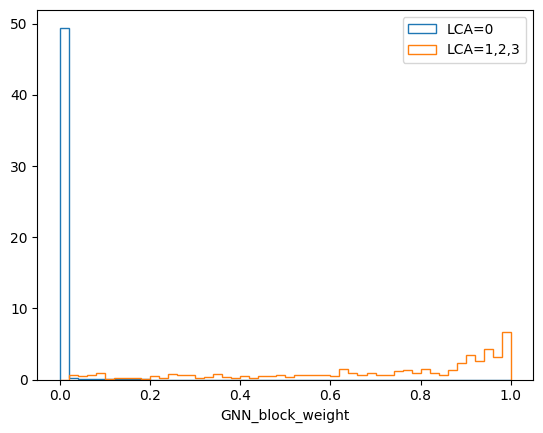

In [62]:
plt.hist(myModel._blocks[4]._network.edge_weights[vdata.y[:,0]==1].detach().cpu().numpy(),density=True, histtype='step',range=(0,1),bins=50,label= "LCA=0")
plt.hist(myModel._blocks[4]._network.edge_weights[vdata.y[:,0]==0].detach().cpu().numpy(), density=True, histtype='step',range=(0,1),bins=50,label= "LCA=1,2,3")
plt.xlabel("GNN_block_weight")
plt.legend()
#plt.savefig("GNNblock5_edge_weights2.png")

In [26]:
optimizer = torch.optim.Adam(myModel.parameters(), lr=0.0001)

In [27]:
epoch_number = 32

EPOCHS = 2

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print("epoch no. ", (epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    myModel.train(True)
    tr_loss, tr_acc= train_one_epoch(epoch_number)
    lst_tr_loss.append(tr_loss)
    lst_tr_acc.append(tr_acc)
#     break
    # We don't need gradients on to do reporting
    myModel.train(False)
    vl_loss, vl_acc= eval_one_epoch(epoch_number)
    lst_vl_loss.append(vl_loss)
    lst_vl_acc.append(vl_acc)
    
    print(f'Train Loss: {tr_loss:03f}')
    
    epoch_number += 1

epoch no.  33
  batch 1234 last_batch 1234 loss: 4.001443981351497
 validation: batch 290 last_batch 290 loss: 4.092606962138209
Train Loss: 4.001444
epoch no.  34
  batch 1234 last_batch 1234 loss: 3.932916738032522
 validation: batch 290 last_batch 290 loss: 4.068098196490058
Train Loss: 3.932917


In [25]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [37]:
epoch_number = 32

EPOCHS = 8

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print("epoch no. ", (epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    myModel.train(True)
    tr_loss, tr_acc= train_one_epoch(epoch_number)
    lst_tr_loss.append(tr_loss)
    lst_tr_acc.append(tr_acc)
#     break
    # We don't need gradients on to do reporting
    myModel.train(False)
    vl_loss, vl_acc= eval_one_epoch(epoch_number)
    lst_vl_loss.append(vl_loss)
    lst_vl_acc.append(vl_acc)
    
    print(f'Train Loss: {tr_loss:03f}')
    
    epoch_number += 1

epoch no.  33
pruning on 
  batch 1234 last_batch 1234 loss: 4.131808488643343
 validation: batch 290 last_batch 290 loss: 4.39454566199204
Train Loss: 4.131808
epoch no.  34
pruning on 
  batch 1234 last_batch 1234 loss: 4.0971095111806735
 validation: batch 290 last_batch 290 loss: 4.390218510298894
Train Loss: 4.097110
epoch no.  35
pruning on 
  batch 1234 last_batch 1234 loss: 4.070656080879694
 validation: batch 290 last_batch 290 loss: 4.386067780955084
Train Loss: 4.070656
epoch no.  36
pruning on 
  batch 1234 last_batch 1234 loss: 4.045172688640304
 validation: batch 290 last_batch 290 loss: 4.394372939241343
Train Loss: 4.045173
epoch no.  37
pruning on 
  batch 1234 last_batch 1234 loss: 4.02175071521555
 validation: batch 290 last_batch 290 loss: 4.399417732501852
Train Loss: 4.021751
epoch no.  38
pruning on 
  batch 1234 last_batch 1234 loss: 4.003487404393609
 validation: batch 290 last_batch 290 loss: 4.401324422606106
Train Loss: 4.003487
epoch no.  39
pruning on 
  b

In [14]:
myModel.load_state_dict(torch.load('model_32_8block_epochs_pruning_latest.pth'))
myModel.eval()

RuntimeError: Error(s) in loading state_dict for EncodeProcessDecode:
	While copying the parameter named "_encoder._network._edge_model._model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 4]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (4) at non-singleton dimension 1',).
	While copying the parameter named "_encoder._network._node_model._model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 4]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (4) at non-singleton dimension 1',).
	While copying the parameter named "_encoder._network._global_model._model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 1]), an exception occurred : ("output with shape [0] doesn't match the broadcast shape [128, 0]",).
	While copying the parameter named "_core._network._edge_block._edge_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 64]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (64) at non-singleton dimension 1',).
	While copying the parameter named "_core._network._node_block._node_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 40]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (40) at non-singleton dimension 1',).
	While copying the parameter named "_core._network._global_block._global_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 32]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (32) at non-singleton dimension 1',).
	While copying the parameter named "_core._network.edge_mlp.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([16, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_core._network.node_mlp.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([16, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.0._network._edge_block._edge_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 32]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (32) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.0._network._node_block._node_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 24]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (24) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.0._network._global_block._global_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 24]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (24) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.0._network.edge_mlp.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([16, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.0._network.node_mlp.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([16, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.1._network._edge_block._edge_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 64]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (64) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.1._network._node_block._node_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 40]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (40) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.1._network._global_block._global_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 32]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (32) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.1._network.edge_mlp.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([16, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.1._network.node_mlp.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([16, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.2._network._edge_block._edge_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 64]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (64) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.2._network._node_block._node_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 40]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (40) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.2._network._global_block._global_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 32]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (32) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.2._network.edge_mlp.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([16, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.2._network.node_mlp.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([16, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.3._network._edge_block._edge_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 64]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (64) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.3._network._node_block._node_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 40]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (40) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.3._network._global_block._global_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 32]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (32) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.3._network.edge_mlp.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([16, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.3._network.node_mlp.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([16, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.4._network._edge_block._edge_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 64]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (64) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.4._network._node_block._node_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 40]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (40) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.4._network._global_block._global_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 32]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (32) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.4._network.edge_mlp.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([16, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.4._network.node_mlp.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([16, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.5._network._edge_block._edge_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 64]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (64) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.5._network._node_block._node_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 40]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (40) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.5._network._global_block._global_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 32]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (32) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.5._network.edge_mlp.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([16, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.5._network.node_mlp.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([16, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.6._network._edge_block._edge_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 64]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (64) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.6._network._node_block._node_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 40]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (40) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.6._network._global_block._global_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 32]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (32) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.6._network.edge_mlp.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([16, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.6._network.node_mlp.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([16, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.7._network._edge_block._edge_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 64]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (64) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.7._network._node_block._node_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 40]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (40) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.7._network._global_block._global_model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 32]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (32) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.7._network.edge_mlp.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([16, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_blocks.7._network.node_mlp.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([16, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_decoder._network._edge_model._model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_decoder._network._node_model._model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).
	While copying the parameter named "_decoder._network._global_model._model.lins.0.weight", whose dimensions in the model are torch.Size([0]) and whose dimensions in the checkpoint are torch.Size([128, 8]), an exception occurred : ('The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 1',).

In [37]:
class1_acc_vl=[]
class2_acc_vl=[]
class3_acc_vl=[]
class4_acc_vl=[]


for vl_acc in lst_vl_acc:
    class1_acc_vl.append(vl_acc[0])
    class2_acc_vl.append(vl_acc[1])
    class3_acc_vl.append(vl_acc[2])
    class4_acc_vl.append(vl_acc[3])

In [38]:
class1_acc_tr=[]
class2_acc_tr=[]
class3_acc_tr=[]
class4_acc_tr=[]


for tr_acc in lst_tr_acc:
    class1_acc_tr.append(tr_acc[0])
    class2_acc_tr.append(tr_acc[1])
    class3_acc_tr.append(tr_acc[2])
    class4_acc_tr.append(tr_acc[3])
    

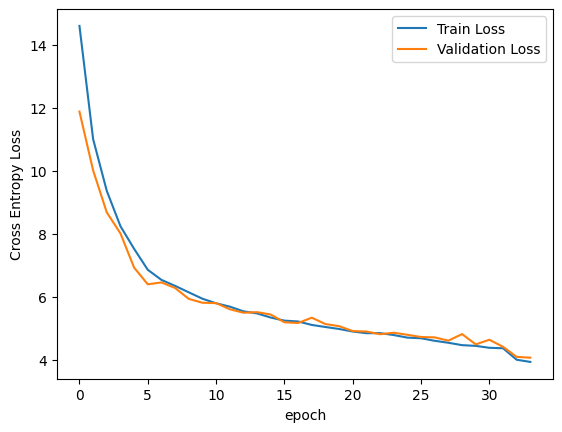

In [44]:
import matplotlib.pyplot as plt
import os
  

    
plt_numlayer = "{}{}".format("No. layers=", NUM_LAYERS)
plt_channel = "{}{}".format("hidden channels=", HIDDEN_CHANNELS)
plt_mlp = "{}{}".format("mlpout=", MLP_OUTPUT_SIZE)
plt_step = "{}{}".format("step=", STEP_SIZE)

plt_filename = "{}{}{}{}".format("L", NUM_LAYERS, "C", HIDDEN_CHANNELS)


plt.plot(lst_tr_loss, label="Train Loss")
plt.plot(lst_vl_loss, label="Validation Loss")

plt.xlabel('epoch')
plt.ylabel('Cross Entropy Loss')
#plt.ylabel('Focal Loss')


plt.legend()
plt.savefig("loss_new_3.png")
# plt.savefig("figures_Oct/"+file_batch+"/loss_"+plt_filename+"_2cores_norm"+".png")

plt.show()

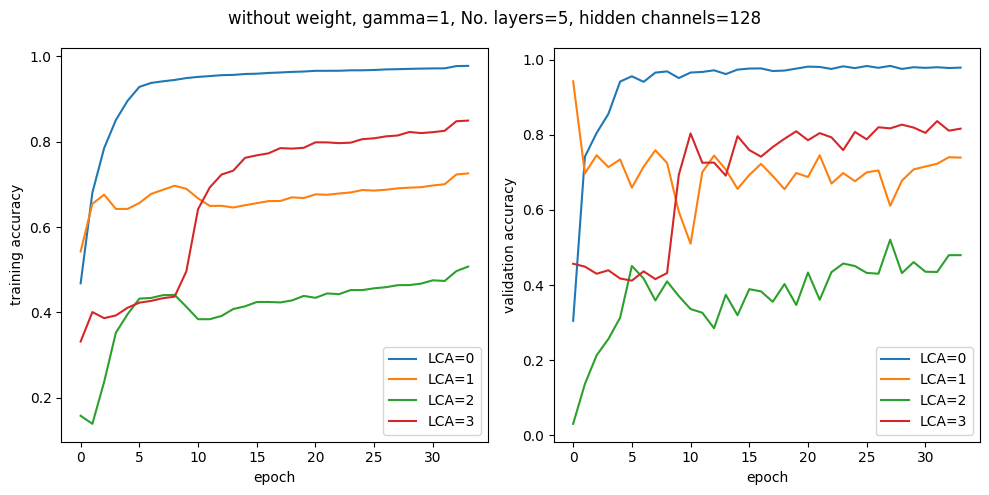

In [45]:
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
# fig.suptitle(plt_numlayer +', '+ plt_channel+', '+plt_mlp+', '+plt_step, fontsize=14)
# fig.suptitle("without weight, gamma=3")
fig.suptitle("without weight, gamma=1, " + plt_numlayer +', '+ plt_channel)

# plt.title("with weight, gamma=3")


axarr[0].plot(class1_acc_tr, label="LCA=0")
axarr[0].plot(class2_acc_tr, label="LCA=1")
axarr[0].plot(class3_acc_tr, label="LCA=2")
axarr[0].plot(class4_acc_tr, label="LCA=3")

axarr[0].set_xlabel('epoch')
axarr[0].set_ylabel('training accuracy')

axarr[0].legend()

axarr[1].plot(class1_acc_vl, label="LCA=0")
axarr[1].plot(class2_acc_vl, label="LCA=1")
axarr[1].plot(class3_acc_vl, label="LCA=2")
axarr[1].plot(class4_acc_vl, label="LCA=3")

axarr[1].set_xlabel('epoch')
axarr[1].set_ylabel('validation accuracy')

axarr[1].legend()

fig.tight_layout()
# fig.subplots_adjust(top=0.88)
plt.savefig("acc_LCAloss_BCE_pruning_from_epoch_30_new_3"+".png")

# plt.savefig("figures_nov/reduced_features/FocalLoss/"+"acc_without_w_g1_" + plt_filename+"_3.png")

# plt.savefig("figures_Oct/"+file_batch+"/acc_"+plt_filename+"_norm"+".png")
# plt.savefig("figures_Oct/"+file_batch+"/acc_"+plt_filename+"_2cores_norm"+".png")



In [30]:
class4_acc_vl[-1]

tensor(0.8311)

In [31]:
class3_acc_vl[-1]

tensor(0.4842)

In [32]:
class2_acc_vl[-1]

tensor(0.7474)

In [33]:
class1_acc_vl[-1]

tensor(0.9785)

In [43]:
torch.save(myModel.state_dict(), 'model_34_6block_epochs_pruning_scattermean.pth')

In [48]:
class4_acc_vl[-1]

tensor(0.8107)

In [49]:
class3_acc_vl[-1]

tensor(0.5039)

In [50]:
class2_acc_vl[-1]

tensor(0.7652)

In [51]:
class1_acc_vl[-1]

tensor(0.9840)

In [39]:
class4_acc_vl[-1]

tensor(0.8163)

In [40]:
class3_acc_vl[-1]

tensor(0.4798)

In [41]:
class2_acc_vl[-1]

tensor(0.7394)

In [42]:
class1_acc_vl[-1]

tensor(0.9788)

In [105]:
vdata.senders

tensor([  1,   2,   3,  ..., 133, 133, 134])

In [131]:
test = torch.tensor([1,2,4,1])

In [120]:
nodes = torch.tensor([0.1,1.1,2.1,4.1,5.1])

In [124]:
nodes = torch.tensor([1.1,2.1,5.1])

In [121]:
nodes[test]

tensor([0.1000, 1.1000, 2.1000, 4.1000, 5.1000])

In [123]:
nodes[test]

tensor([1.1000, 2.1000, 5.1000])

In [127]:
nodes[relabelled_tensor]

tensor([1.1000, 2.1000, 5.1000])

In [132]:
edge_indices_concat = test
unique_elements, inverse_indices = torch.unique(edge_indices_concat, sorted=True, return_inverse=True)
relabelled_tensor = inverse_indices

In [133]:
relabelled_tensor

tensor([0, 1, 2, 0])

In [108]:
vdata.senders

tensor([  1,   2,   3,  ..., 133, 133, 134])

In [109]:
vdata.receivers

tensor([  0,   0,   0,  ..., 134, 135, 135])

In [134]:
vdata.nodes[test]

tensor([[-6.7957e+00,  3.6431e+00,  2.4472e-01,  3.9207e-03, -1.3510e+00,
         -3.6156e+00, -8.5074e+00, -1.0527e+01],
        [-8.4493e+00,  1.7830e+00, -1.4563e+00, -2.0323e-01, -9.7018e-01,
         -7.0300e+00, -4.3188e+00, -8.4471e+00],
        [-5.8492e+00,  5.7001e+00,  3.6310e+00,  1.9951e-01, -3.5947e+00,
         -6.4097e-01, -1.3515e+01, -1.3911e+01],
        [-6.7957e+00,  3.6431e+00,  2.4472e-01,  3.9207e-03, -1.3510e+00,
         -3.6156e+00, -8.5074e+00, -1.0527e+01]], grad_fn=<IndexBackward0>)